# Align and Plot Source Image on Destination Coordinates with SIFT

In [115]:
import importlib
import json
import os
import pickle as pkl
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString

import cv2
import geojson
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
import re
from pycodex import align, io, metadata
from rasterio.features import rasterize
from shapely.geometry import LineString, MultiPolygon, Point, Polygon
from tqdm import tqdm

importlib.reload(align)

io.setup_gpu("0,1,2,3")

# 00. Data Preparation

In [32]:
def convert_to_polygon(gdf):
    """
    Convert geometries in a given GeoDataFrame to polygons and return a new GeoDataFrame with polygon geometries.

    This function handles both Polygon and MultiPolygon geometries. For MultiPolygon geometries,
    each individual Polygon within the MultiPolygon is extracted and added to the result.

    Parameters:
    ----------
    gdf : geopandas.GeoDataFrame
        A GeoDataFrame containing various geometry types (e.g., points, lines, polygons, multipolygons).

    Returns:
    -------
    gdf_polygons : geopandas.GeoDataFrame
        A new GeoDataFrame containing all successfully converted polygon geometries from the input `gdf`.

    Notes:
    -----
    - Only Polygon and MultiPolygon geometries are processed.
    - Geometries that cannot be converted to polygons, such as LineStrings or Points, will be skipped with a warning.
    """
    polygons = []
    for geom in gdf.geometry:
        try:
            if isinstance(geom, Polygon):
                polygons.append(geom)
            elif isinstance(geom, MultiPolygon):
                # Extract each polygon from the MultiPolygon
                polygons.extend(list(geom.geoms))
            else:
                print(f"[WARNING] Skipped non-polygon geometry: {geom}")
        except Exception as e:
            print(f"[ERROR] Failed to process geometry {geom}: {e}")

    # Create a new GeoDataFrame with the extracted polygons
    gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs=gdf.crs)
    return gdf_polygons

def generate_mask(im, gdf_polygons):
    """
    Generate a binary mask from a set of polygons that aligns with a given image.

    Parameters:
    ----------
    im : numpy.ndarray
        The input image as a NumPy array with shape (height, width, channels).
        The mask will have the same spatial dimensions (height, width) as this image.

    gdf_polygons : geopandas.GeoDataFrame
        A GeoDataFrame containing polygon geometries. These polygons represent the regions
        to be filled in the mask. It is assumed that the polygons are in the same coordinate
        system as the image.

    Returns:
    -------
    im_mask : numpy.ndarray
        A 2D binary mask with the same height and width as the input image. The mask has
        a value of 1 in the regions covered by the polygons and 0 elsewhere.

    Notes:
    -----
    - The function uses `rasterio.features.rasterize` to create a binary mask.
    - This function assumes that `gdf_polygons` and `im` share the same coordinate system
      or spatial reference. If not, `gdf_polygons` should be transformed to match `im`.

    """
    height, width = im.shape[:2]
    im_mask = rasterize(
        [(geom, 1) for geom in gdf_polygons.geometry],  # Set polygons to value 1
        out_shape=(height, width),  # Set to image dimensions
        fill=0,  # Background set to 0
        dtype="uint8",
    )
    return im_mask


In [116]:
dir_qptiff = "/mnt/nfs/home/yaoyuyeo/IN_DEPTH/DLBCL/CODEX-CosMx_97.1_L2/Scan1"
qptiff_files = [file for file in os.listdir(dir_qptiff) if "raw.qptiff" in file]

dir_geojson = "/mnt/nfs/home/yaoyuyeo/IN_DEPTH/DLBCL/CODEX-CosMx_97.1_L2/Scan_qpath_project"
geojson_files = [
    f"{file} - resolution #1.geojson"
    for file in qptiff_files
    if f"{file} - resolution #1.geojson" in os.listdir(dir_geojson)
]

for i in tqdm(range(len(qptiff_files))):
    tifffile_qptiff = tifffile.TiffFile(os.path.join(dir_qptiff, qptiff_files[i]))
    im_qptiff = tifffile_qptiff.asarray()

    path_geojson = os.path.join(dir_geojson, geojson_files[i])
    with open(path_geojson, "r") as f:
        geojson_data = json.load(f)
    # Convert GeoJSON to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
    gdf_polygons = convert_to_polygon(gdf)

    # Raw XML string extracted from the OME-TIFF metadata
    xml_str = tifffile_qptiff.pages[0].tags["ImageDescription"].value
    json_data = re.search(r"<ScanProfile>\s*(\{.*\})\s*</ScanProfile>", xml_str, re.DOTALL).group(1)
    data_dict = json.loads(json_data)

    channels = [channel["name"] for channel in data_dict["experimentDescription"]["channels"]]
    cycle = re.search(r"Cycle\d+", qptiff_files[i]).group(0)

    dir_output = f"/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/01_tiff/{cycle}"
    os.makedirs(dir_output, exist_ok=True)

    for i, channel in tqdm(enumerate(channels), total=len(channels), desc=f"Processing {cycle}"):
        im = im_qptiff[i]
        im_mask = generate_mask(im, gdf_polygons)
        im[im_mask == 0] = 0
        tifffile.imwrite(os.path.join(dir_output, f"{channel}.tiff"), im)


100%|██████████| 15/15 [32:52<00:00, 131.53s/it]


# 00. Main Parameters

In [401]:
########################################################################################################################
# Directory for reference images (destination images)
dir_dst = "/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/01_tiff/Cycle0"

# Directory for images to align on the reference images (source images)
dir_src = "/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/01_tiff/Cycle14"

# Directory for paramters output
# id = "run1=Cycle0_run2=Cycle1"
id = f"run1={os.path.basename(dir_dst)}_run2={os.path.basename(dir_src)}"
dir_sift = os.path.join("/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/02_sift_parameter", id)
########################################################################################################################

print(id)

run1=Cycle0_run2=Cycle14


If the directories for the destination and source images are valid, a "Summary of Markers" will be printed. 

In [402]:
# destination images
dst_metadata_dict = io.organize_metadata_fusion(dir_dst, subfolders=False)
dst_unique_markers, _, _, _ = metadata.summary_markers(dst_metadata_dict)

Summary of Markers:
- Total unique markers: 4
- Unique markers: 4 ['AF750', 'ATTO550', 'CY5', 'DAPI']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []



In [418]:
# source images
src_metadata_dict = io.organize_metadata_fusion(dir_src, subfolders=False)
src_unique_markers, _, _, _ = metadata.summary_markers(src_metadata_dict)

Summary of Markers:
- Total unique markers: 4
- Unique markers: 4 ['AF750', 'ATTO550', 'CY5', 'DAPI']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []



Check the files within the output directory. 

In [404]:
!ls $dir_sift

sift_parameter.pkl


# 01. Data Overview

In [405]:
# Common markers in both destination and soruce images
[marker for marker in dst_unique_markers if marker in src_unique_markers]

['AF750', 'ATTO550', 'CY5', 'DAPI']

In [406]:
########################################################################################################################
# Select a common marker of source and destination imges for SIFT alignment
marker_dst = "DAPI.tiff"
marker_src = "DAPI.tiff"
########################################################################################################################

im_dst = tifffile.imread(os.path.join(dir_dst, marker_dst))
im_src = tifffile.imread(os.path.join(dir_src, marker_src))

Preview your image to check whether the direction of your images are correct. 

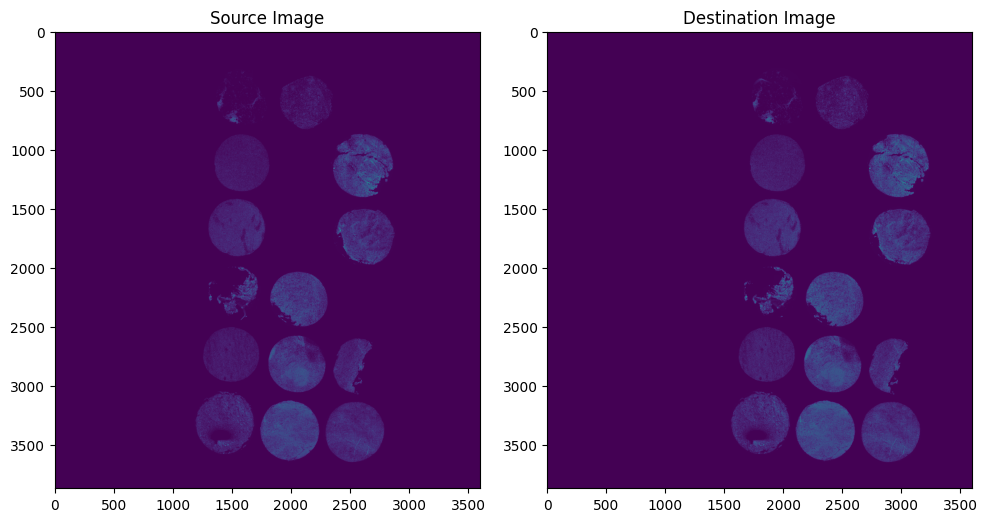

In [407]:
step_pv = 8

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs = axs.flatten()
axs[0].imshow(im_src[::step_pv, ::step_pv])
axs[0].set_title("Source Image")
axs[1].imshow(im_dst[::step_pv, ::step_pv])
axs[1].set_title("Destination Image")
plt.tight_layout()
plt.show()

In [408]:
########################################################################################################################
src_rot90cw = 0
src_hflip = False
########################################################################################################################

for i in range(src_rot90cw): 
    im_src = cv2.rotate(im_src, cv2.ROTATE_90_CLOCKWISE)
if src_hflip:
    im_src = cv2.flip(im_src, 1)

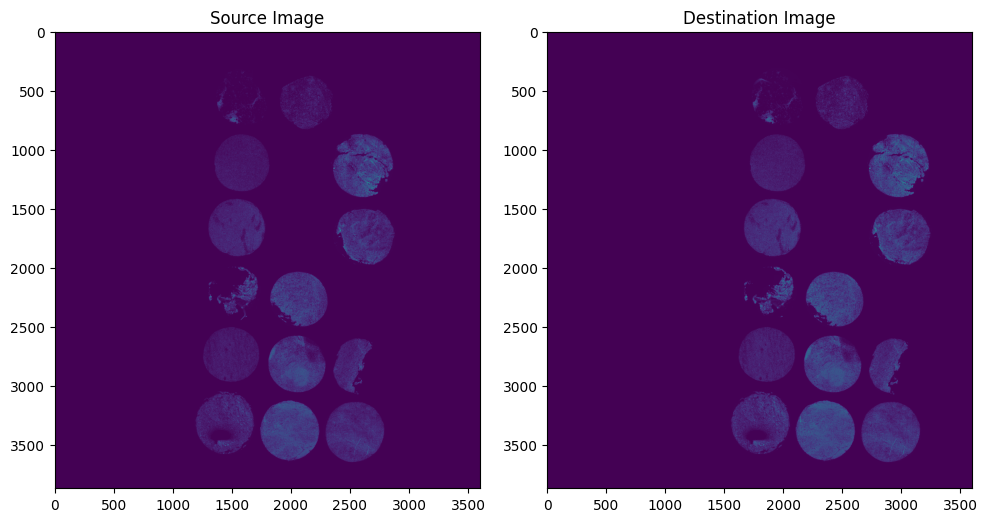

In [409]:
step_pv = 8

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs = axs.flatten()
axs[0].imshow(im_src[::step_pv, ::step_pv])
axs[0].set_title("Source Image")
axs[1].imshow(im_dst[::step_pv, ::step_pv])
axs[1].set_title("Destination Image")
plt.tight_layout()
plt.show()

# 02. SIFT Alignment

In [410]:
########################################################################################################################
sift_step = 8
########################################################################################################################

sift_matcher = align.SIFTMatcher(im_src, im_dst, step=sift_step)

Initialize SIFT detector
Find keypoints and descriptors
Initialize matcher
Match descriptors


This intersection percentages plot assists in selecting an appropriate Lowe’s ratio threshold for SIFT alignment. 

For two images with minimal rotation (as in our case, where there is no rotation between the two images), a lower intersection percentage indicates better alignment performance.

100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


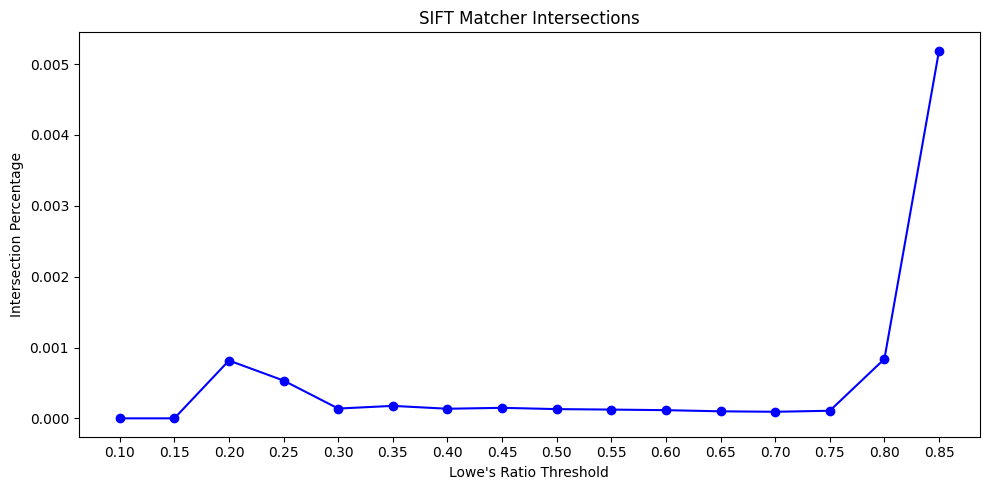

In [411]:
sift_matcher.find_kp_intersections()
sift_matcher.plot_kp_intersections(figsize=(10, 5))

Apply Lowe's ratio threshold


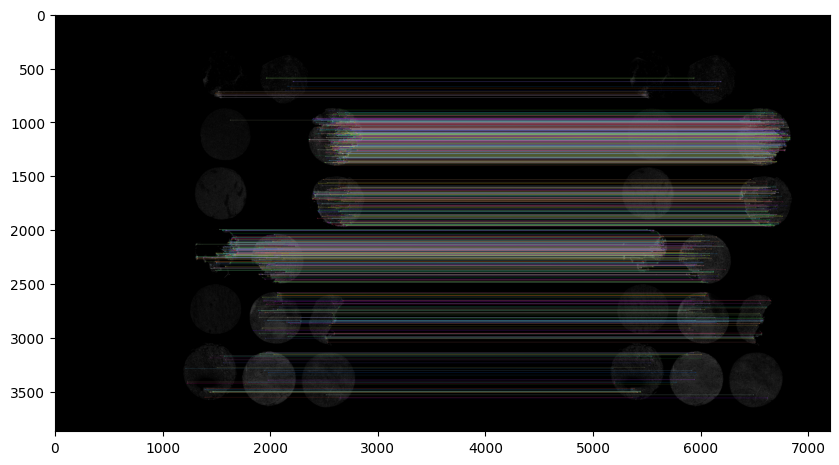

In [412]:
########################################################################################################################
# Set appropriate Lowe's ratio threshold
ratio_threshold = 0.50
########################################################################################################################

sift_matcher.set_lowe_ratio_threshold(ratio_threshold, figsize=(10, 10))

In [413]:
H, H_inverse = sift_matcher.compute_affine_matrix()
im_src_trans, blank_mask = align.apply_affine_transformation(im_src, im_dst.shape, H_inverse)

Extract matched keypoints
Compute affine transformation


In [414]:
# percentage of non-overlap region
f"masked percentage (%): {np.mean(blank_mask) * 100}"

'masked percentage (%): 10.26756399386305'

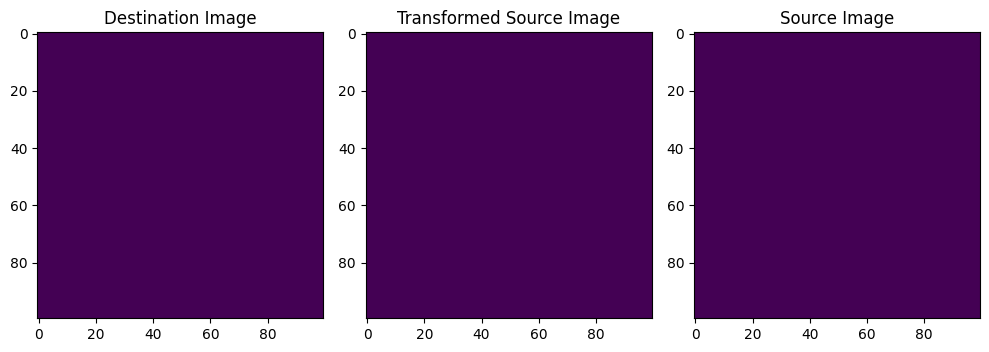

In [415]:
########################################################################################################################
# Select an appropriate region to check the SIFT alignment performance
x_beg = 2000
y_beg = 2000
length = 100
########################################################################################################################

im_dst_sm = im_dst[y_beg : (y_beg + length), x_beg : (x_beg + length)]
im_src_trans_sm = im_src_trans[y_beg : (y_beg + length), x_beg : (x_beg + length)]
im_src_sm = im_src[y_beg : (y_beg + length), x_beg : (x_beg + length)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
axs = axs.flatten()

axs[0].imshow(im_dst_sm)
axs[0].set_title("Destination Image")

axs[1].imshow(im_src_trans_sm)
axs[1].set_title("Transformed Source Image")

axs[2].imshow(im_src_sm)
axs[2].set_title("Source Image")

plt.tight_layout()
plt.show()

# 03. Parameter Export

In [416]:
os.makedirs(dir_output, exist_ok=True)
data = {"H_inverse": H_inverse, "blank_mask": blank_mask, "output_shape": im_dst.shape}

os.makedirs(dir_sift, exist_ok=True)
path_sift = os.path.join(dir_sift, "sift_parameter.pkl")
if os.path.exists(path_sift):
    print(f"File already exists: {path_sift}.")
else:
    with open(path_sift, "wb") as f:
        pkl.dump(data, f)
    print(f"File saved: {path_sift}.")

File already exists: /mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/02_sift_parameter/run1=Cycle0_run2=Cycle14/sift_parameter.pkl.


# 04. Final Check for Main Parameters

In [417]:
for item in [id, dir_dst, dir_src, os.path.join(dir_sift, "sift_parameter.pkl")]:
    print(item)

run1=Cycle0_run2=Cycle14
/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/01_tiff/Cycle0
/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/01_tiff/Cycle14
/mnt/nfs/home/wenruiwu/projects/alignment_dlbcl/02_sift_parameter/run1=Cycle0_run2=Cycle14/sift_parameter.pkl
